In [1]:
import numpy as np
import tcbench as tcb
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = tcb.load_parquet(tcb.DATASETS.MIRAGE19, min_pkts=10)
df = df.drop(columns=['conn_id', 'android_name'])
df = df.rename(columns={'flow_metadata_bf_label': 'label', 
                        'flow_metadata_bf_labeling_type': 'labeling_type',
                        'packet_data_l4_raw_payload': 'raw_payload', 
                        'flow_metadata_bf_l4_payload_bytes': 'payload_bytes',
                        'flow_metadata_bf_duration': 'duration',
                        'timetofirst': 'time_to_first',})
print(df.columns)
print(df.shape)

Index(['row_id', 'raw_payload', 'label', 'labeling_type', 'payload_bytes',
       'duration', 'strings', 'device_name', 'app', 'src_ip', 'src_port',
       'dst_ip', 'dst_port', 'proto', 'packets', 'pkts_size', 'pkts_dir',
       'time_to_first'],
      dtype='object')
(64172, 18)


In [3]:
def process_flow(row):
    feature_vector = []
    pkts_size = np.array(row['pkts_size']) if len(row['pkts_size']) > 0 else np.array([0])
    feature_vector.extend([np.mean(pkts_size), np.std(pkts_size), np.min(pkts_size), np.max(pkts_size)])
    return feature_vector

vectors_baseline = np.array(df.apply(process_flow, axis=1).tolist())
scaler = StandardScaler()
vectors_baseline = scaler.fit_transform(vectors_baseline)
labels_baseline = df['label'].factorize()[0]

np.save('artifacts-mirage19/baseline_vectors.npy', vectors_baseline)
np.save('artifacts-mirage19/baseline_labels.npy', labels_baseline)

In [4]:
vectors_embeddings = np.load('artifacts-mirage19/embeddings_vectors.npy')
labels_embeddings = np.load('artifacts-mirage19/embeddings_labels.npy')
pca = PCA(n_components=10)
vectors_embeddings = pca.fit_transform(vectors_embeddings)

In [5]:
def kmeans (feature_matrix, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_clusters = kmeans.fit_predict(feature_matrix)
    return kmeans_clusters

kmeans_baseline = kmeans(vectors_baseline, 20)
kmeans_embeddings = kmeans(vectors_embeddings, 20)


In [6]:
def dbscan (feature_matrix):
    dbscan = DBSCAN(eps = 0.2, min_samples = 100)
    dbscan_clusters = dbscan.fit_predict(feature_matrix)
    return dbscan_clusters

dbscan_baseline = dbscan(vectors_baseline)
dbscan_embeddings = dbscan(vectors_embeddings)

In [7]:
sil_score_baseline = silhouette_score(vectors_baseline, kmeans_baseline)
print(f"Baseline Silhouette Score: {sil_score_baseline:.4f}")
sil_score_embeddings = silhouette_score(vectors_embeddings, kmeans_embeddings)
print(f"Embeddings Silhouette Score: {sil_score_embeddings:.4f}")

ari_score_baseline = adjusted_rand_score(labels_baseline, kmeans_baseline)
print(f"Baseline Adjusted Rand Index (ARI): {ari_score_baseline:.4f}")
ari_score_embeddings = adjusted_rand_score(labels_embeddings, kmeans_embeddings)
print(f"Embeddings Adjusted Rand Index (ARI): {ari_score_embeddings:.4f}")

nmi_score_baseline = normalized_mutual_info_score(labels_baseline, kmeans_baseline)
print(f"Baseline Normalized Mutual Info (NMI): {nmi_score_baseline:.4f}")
nmi_score_embeddings = normalized_mutual_info_score(labels_embeddings, kmeans_embeddings)
print(f"Embeddings Normalized Mutual Info (NMI): {nmi_score_embeddings:.4f}")

Baseline Silhouette Score: 0.3360
Embeddings Silhouette Score: 0.2047
Baseline Adjusted Rand Index (ARI): 0.0528
Embeddings Adjusted Rand Index (ARI): 0.2992
Baseline Normalized Mutual Info (NMI): 0.1219
Embeddings Normalized Mutual Info (NMI): 0.4251


In [8]:
valid_points_baseline = dbscan_baseline != -1
valid_points_embeddings = dbscan_embeddings != -1
sil_score_baseline = silhouette_score(vectors_baseline[valid_points_baseline], dbscan_baseline[valid_points_baseline])
print(f"Baseline Silhouette Score: {sil_score_baseline:.4f}")
sil_score_embeddings = silhouette_score(vectors_embeddings[valid_points_embeddings], dbscan_embeddings[valid_points_embeddings])
print(f"Embeddings Silhouette Score: {sil_score_embeddings:.4f}")

ari_score_baseline = adjusted_rand_score(labels_baseline, dbscan_baseline)
print(f"Baseline Adjusted Rand Index (ARI): {ari_score_baseline:.4f}")
ari_score_embeddings = adjusted_rand_score(labels_embeddings, dbscan_embeddings)
print(f"Embeddings Adjusted Rand Index (ARI): {ari_score_embeddings:.4f}")

nmi_score_baseline = normalized_mutual_info_score(labels_baseline, dbscan_baseline)
print(f"Baseline Normalized Mutual Info (NMI): {nmi_score_baseline:.4f}")
nmi_score_embeddings = normalized_mutual_info_score(labels_embeddings, dbscan_embeddings)
print(f"Embeddings Normalized Mutual Info (NMI): {nmi_score_embeddings:.4f}")

Baseline Silhouette Score: -0.0252
Embeddings Silhouette Score: 0.7841
Baseline Adjusted Rand Index (ARI): 0.0141
Embeddings Adjusted Rand Index (ARI): -0.0015
Baseline Normalized Mutual Info (NMI): 0.1131
Embeddings Normalized Mutual Info (NMI): 0.1083


In [9]:
def calculate_within_class_distances(feature_matrix, true_labels, metric):
    class_distances = {}
    unique_labels = np.unique(true_labels)

    for label in unique_labels:
        class_indices = np.where(true_labels == label)[0]
        class_features = feature_matrix[class_indices]
        distances = squareform(pdist(class_features, metric))
        class_distances[label] = distances

    return class_distances

def calculate_between_class_distances(feature_matrix, true_labels, metric):
    class_distances = {}
    unique_labels = np.unique(true_labels)

    for label in unique_labels:
        class_indices = np.where(true_labels == label)[0]
        other_indices = np.where(true_labels != label)[0]
        class_features = feature_matrix[class_indices]
        other_features = feature_matrix[other_indices]
        distances = cdist(class_features, other_features, metric)
        class_distances[label] = distances.flatten()

    return class_distances

In [10]:
distances_within_baseline = calculate_within_class_distances(vectors_baseline, labels_baseline, metric='euclidean')
distances_between_baseline = calculate_between_class_distances(vectors_baseline, labels_baseline, metric='euclidean')

In [13]:
distances_within_embeddings = calculate_within_class_distances(vectors_embeddings, labels_embeddings, metric='euclidean')
distances_between_embeddings = calculate_between_class_distances(vectors_embeddings, labels_embeddings, metric='euclidean')

In [15]:
distances_within_embeddings_cosine = calculate_within_class_distances(vectors_embeddings, labels_embeddings, metric='cosine')
distances_between_embeddings_cosine = calculate_between_class_distances(vectors_embeddings, labels_embeddings, metric='cosine')

In [11]:
def plot_distance_histograms(class_distances_1, class_distances_2):
    fig, axes = plt.subplots(4, 5, figsize=(20, 15))
    axes = axes.flatten()

    for i, ((label1, distances1), (label2, distances2)) in enumerate(zip(class_distances_1.items(), class_distances_2.items())):
        ax = axes[i]
        distances1 = distances1[np.triu_indices_from(distances1, k=1)]
        
        ax.hist(distances1, bins=30, alpha=0.5, color='blue', label='Within class', density=True)
        ax.hist(distances2, bins=30, alpha=0.5, color='red', label='Between classes', density=True)
        
        ax.set_title(f'Class {label1}')
        ax.set_xlabel('Distance')
        ax.set_ylabel('Density')
        ax.legend()

    plt.tight_layout()
    plt.show()

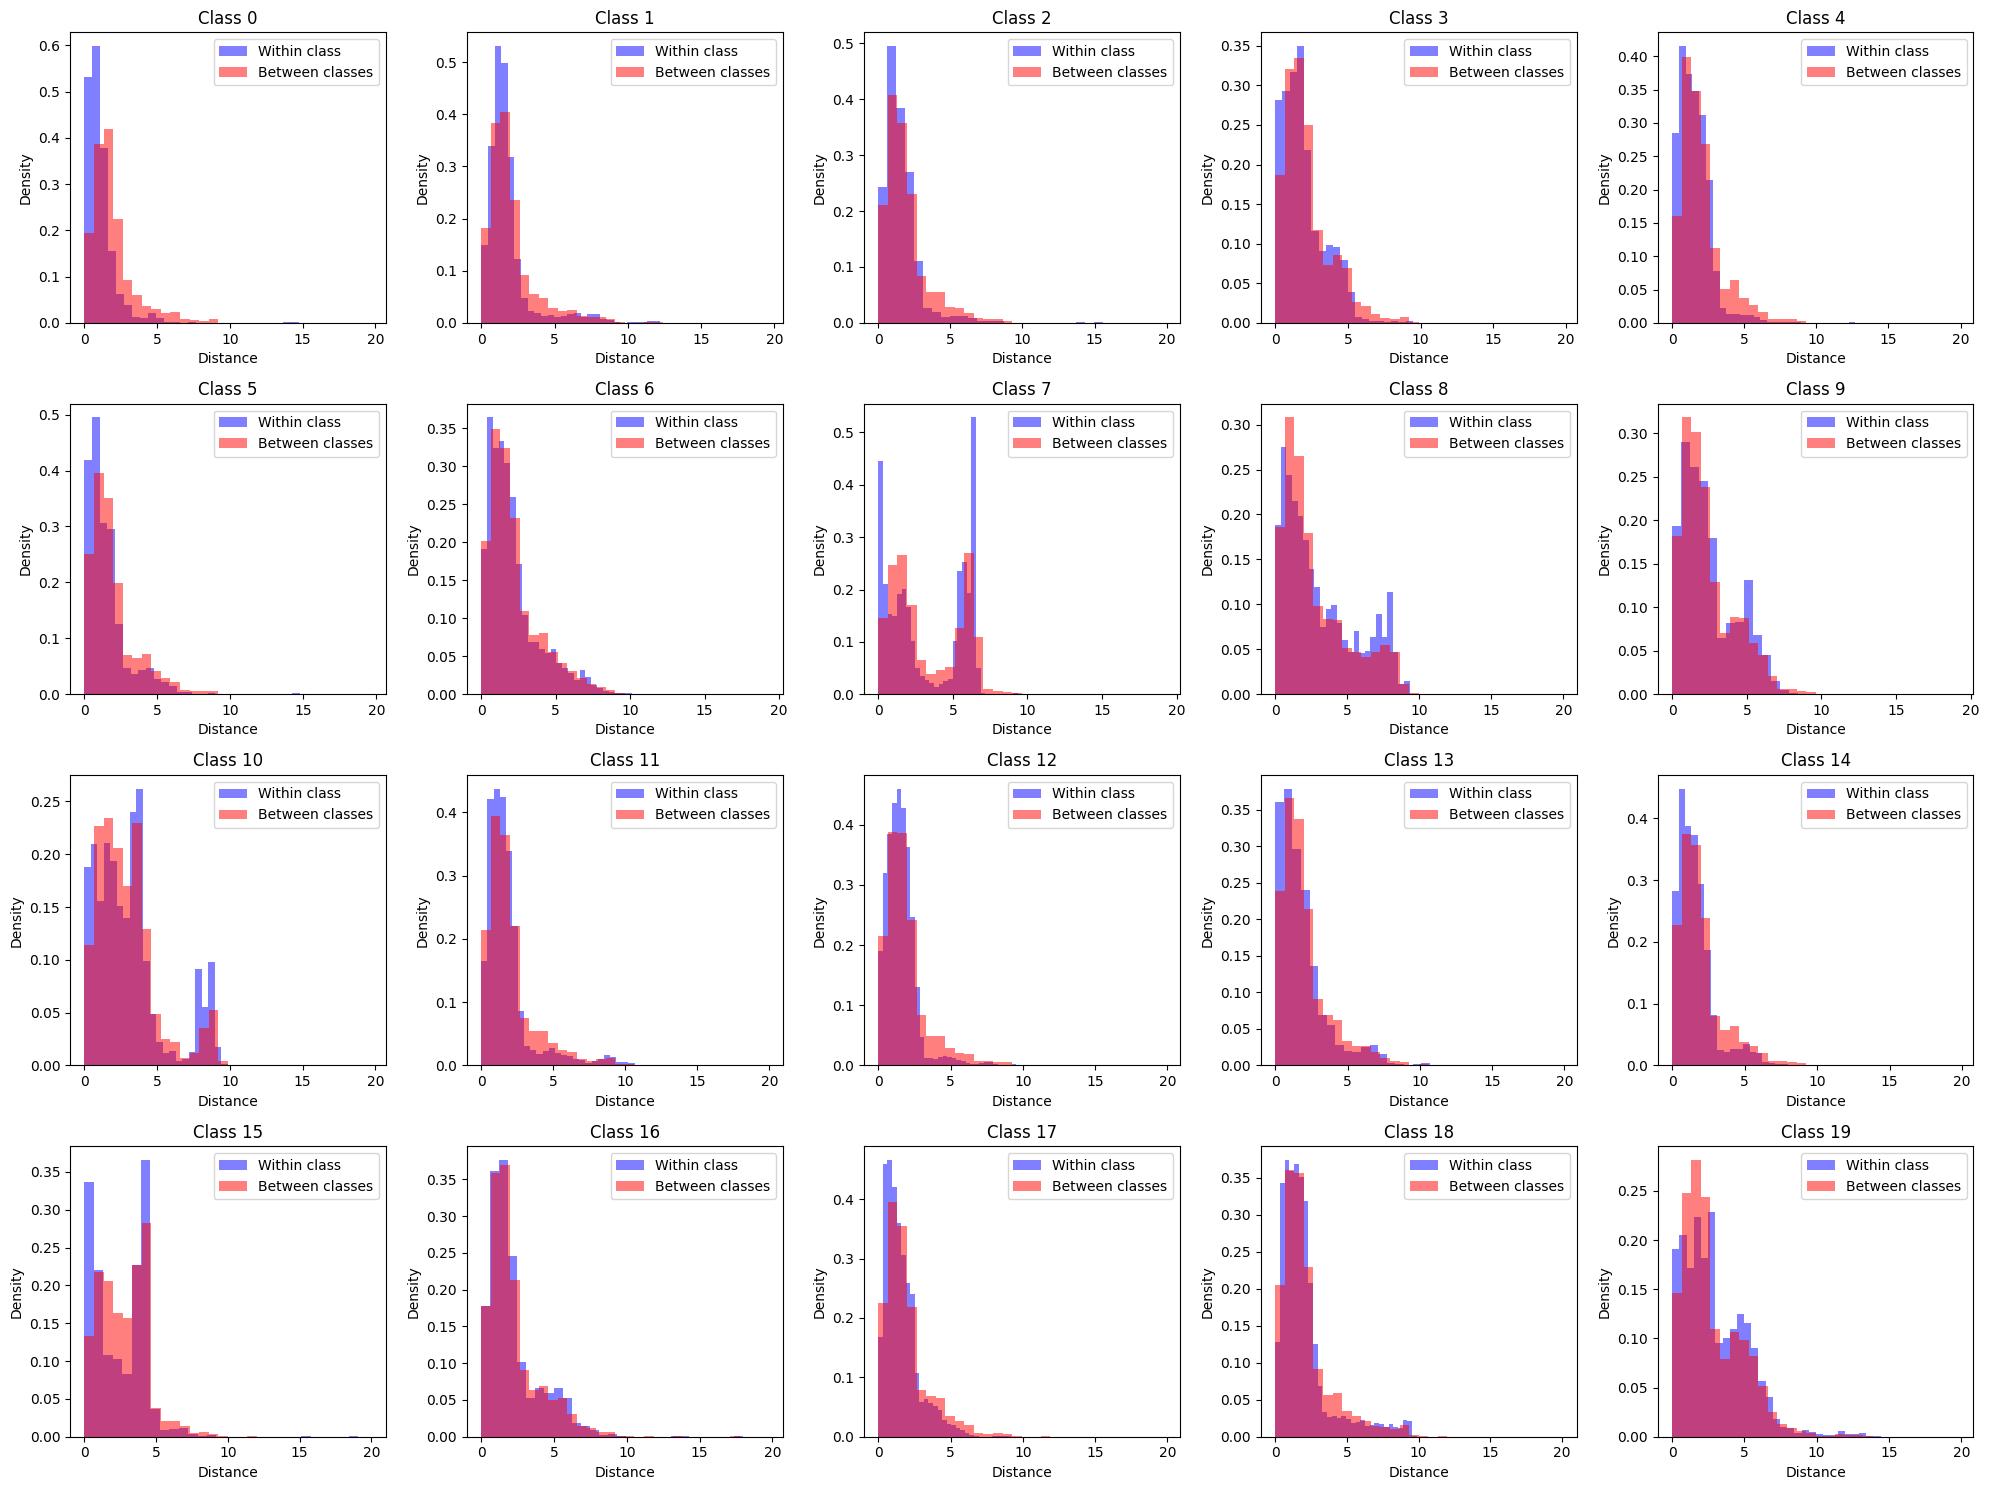

In [12]:
plot_distance_histograms(distances_within_baseline, distances_between_baseline)

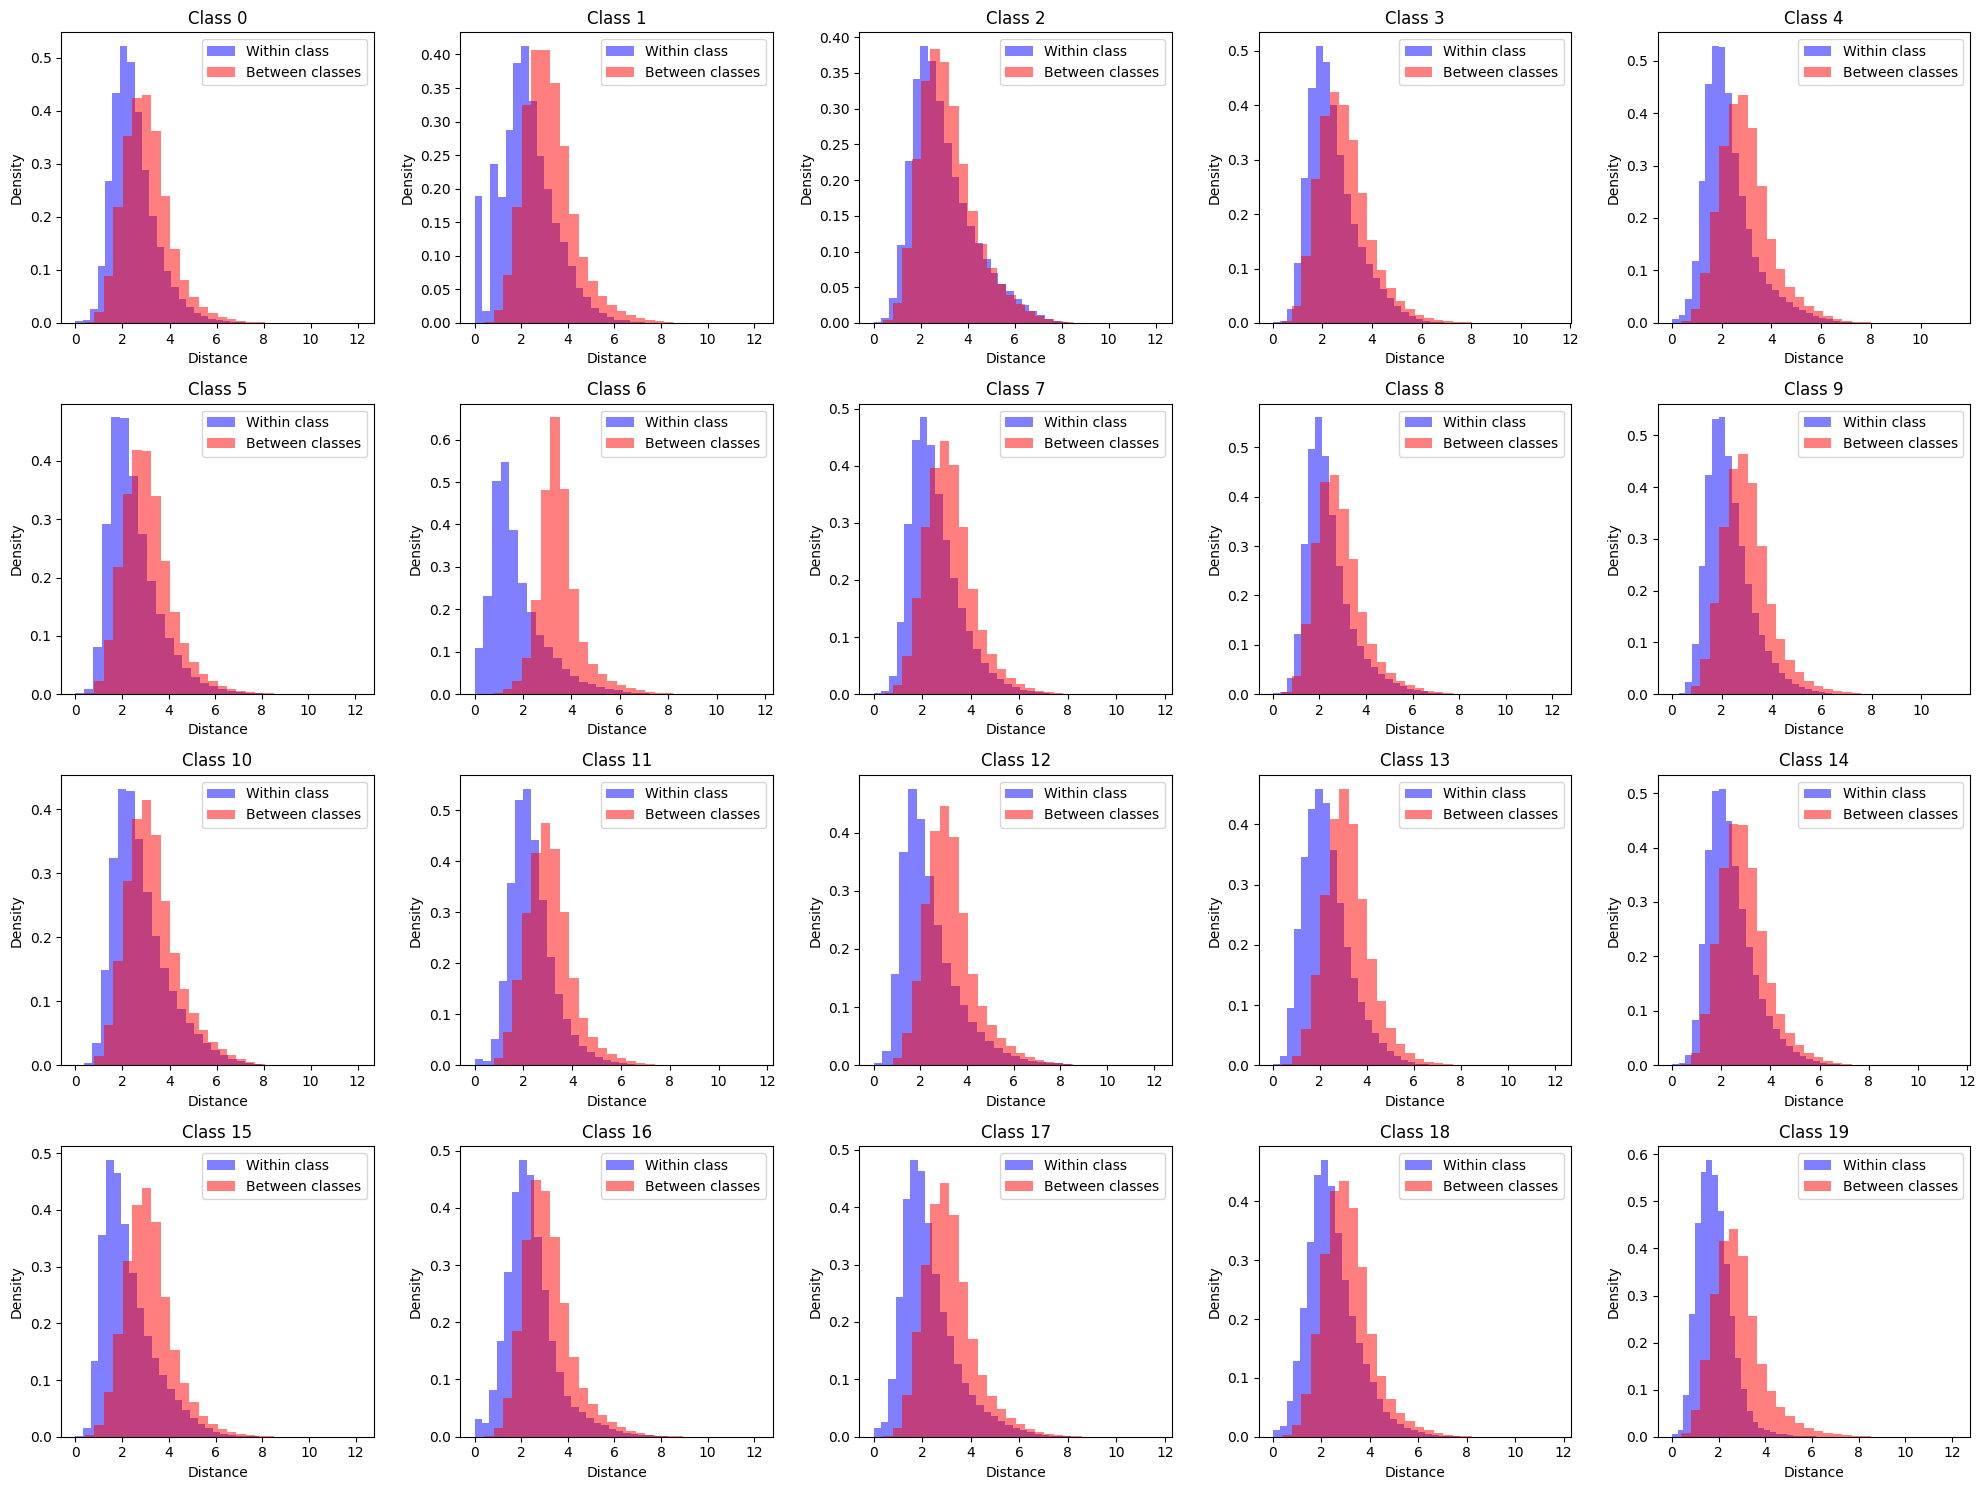

In [14]:
plot_distance_histograms(distances_within_embeddings, distances_between_embeddings)

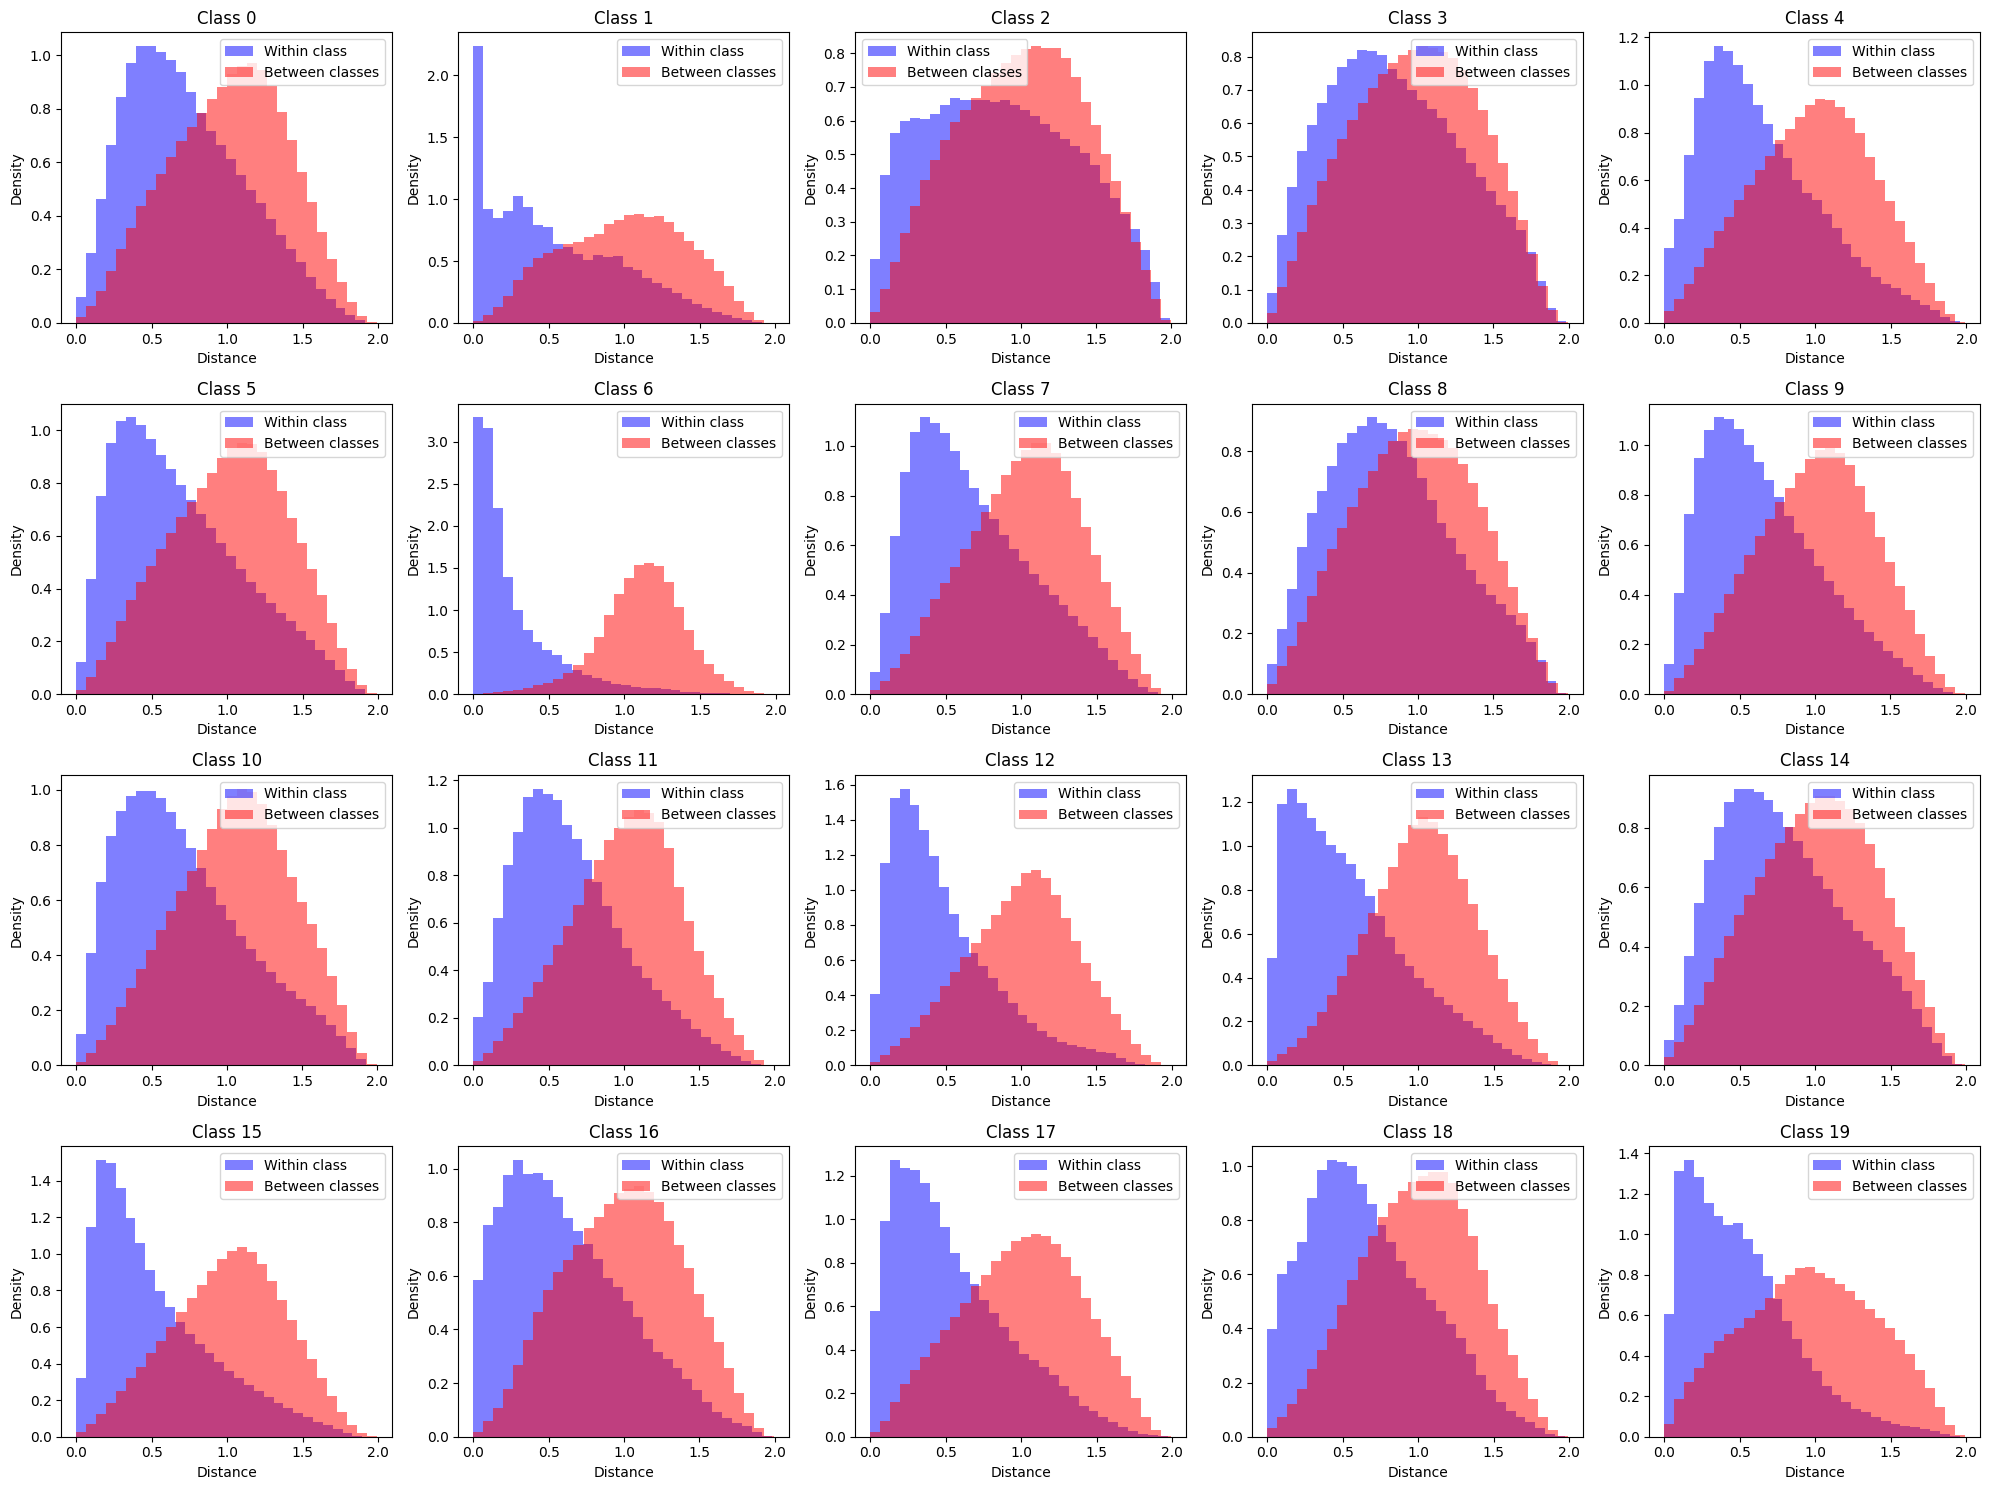

In [16]:
plot_distance_histograms(distances_within_embeddings_cosine, distances_between_embeddings_cosine)